# Effective spread
|                |   |
:----------------|---|
| <span style="color:cadetblue">**Nombre**</span>     | Ana Sofía Hinojosa Bale  |
| <span style="color:cadetblue">**Fecha**</span>       | 28 de agosto 2025        |
| <span style="color:cadetblue">**Expediente**</span>  | 742594                   |

Using Roll's model for effective spreads, do the following using the `aapl_5m_train.csv` dataset:

- Determine the effective spread using the block method `cov([dt1, dt2, dt3], [dt4, dt5, dt6])`
- Determine the effective spread using the serial covariance `cov([dt1, dt2, dt3], [dt2, dt3, dt4])`
- Infer the last operation type
- Calculate the Bid & Ask price using a window size of [5, 10, 20, 50, 100]
- Find the average spread of AAPL and analyze the spreads of all methods to find which one fits best for this time series
- Upload a jupyter notebook with the results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Datos

In [2]:
data = pd.read_csv('aapl_5m_train.csv').drop(columns = ['Unnamed: 0', 'Timestamp', 'Gmtoffset', 'Volume'])
data['Difference'] = data['Close'].diff()
data = data.dropna().reset_index(drop=True)

ba = []
for i in data['Difference']:
    if i > 0: 
        ba.append('ask')
    else:
        ba.append('bid')
data['BA'] = ba

data_block = data.copy()
data_cov = data.copy()
data

,Datetime,Open,High,Low,Close,Difference,BA
0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,-0.919998,bid
1,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,0.169998,ask
2,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,0.190003,ask
3,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,-0.660004,bid
4,2021-01-04 14:55:00,132.000000,132.089996,131.300003,131.448898,-0.141098,bid
...,...,...,...,...,...,...,...
39567,2022-12-30 20:40:00,129.029998,129.130004,128.919998,129.054992,0.014999,ask
39568,2022-12-30 20:45:00,129.059997,129.399993,129.020004,129.380004,0.325012,ask
39569,2022-12-30 20:50:00,129.375000,129.929992,129.330001,129.764404,0.384400,ask
39570,2022-12-30 20:55:00,129.764999,129.949996,129.619995,129.949996,0.185592,ask


## Block method

In [3]:
def block_method(data, window):
    
    for w in window:
        diffs = data['Difference'].values
        cov = [np.nan] * len(data)
        n = len(data) - 2 * w - 1

        for i in range(n):
            b1 = diffs[i:i+w]
            b2 = diffs[i+w:i+2*w]

            cov[i + 2*w - 1] = np.abs(np.cov(b1, b2)[0, 1])

        data[f'Cov_{w}'] = cov
        data[f'Spread_{w}'] = 2 * np.sqrt(data[f'Cov_{w}'])

    for i in range(len(window)):
        data[f'Bid_{window[i]}'] = np.where(data['Difference'] > 0, 
            data['Close'] - data[f'Spread_{window[i]}'], data['Close'])
        data[f'Ask_{window[i]}'] = np.where(data['Difference'] > 0, 
            data['Close'], data['Close'] + data[f'Spread_{window[i]}'])

    return data

In [4]:
window = [5, 10, 20, 50, 100]
block_method(data_block, window)

,Datetime,Open,High,Low,Close,Difference,BA,Cov_5,Spread_5,Cov_10,...,Bid_5,Ask_5,Bid_10,Ask_10,Bid_20,Ask_20,Bid_50,Ask_50,Bid_100,Ask_100
0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,-0.919998,bid,NaN,NaN,NaN,...,131.889999,NaN,131.889999,NaN,131.889999,NaN,131.889999,NaN,131.889999,NaN
1,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,0.169998,ask,NaN,NaN,NaN,...,NaN,132.059997,NaN,132.059997,NaN,132.059997,NaN,132.059997,NaN,132.059997
2,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,0.190003,ask,NaN,NaN,NaN,...,NaN,132.250000,NaN,132.250000,NaN,132.250000,NaN,132.250000,NaN,132.250000
3,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,-0.660004,bid,NaN,NaN,NaN,...,131.589996,NaN,131.589996,NaN,131.589996,NaN,131.589996,NaN,131.589996,NaN
4,2021-01-04 14:55:00,132.000000,132.089996,131.300003,131.448898,-0.141098,bid,NaN,NaN,NaN,...,131.448898,NaN,131.448898,NaN,131.448898,NaN,131.448898,NaN,131.448898,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39567,2022-12-30 20:40:00,129.029998,129.130004,128.919998,129.054992,0.014999,ask,0.005183,0.143989,0.001034,...,128.911003,129.054992,128.990683,129.054992,128.968943,129.054992,129.008188,129.054992,128.854473,129.054992
39568,2022-12-30 20:45:00,129.059997,129.399993,129.020004,129.380004,0.325012,ask,0.010577,0.205689,0.000199,...,129.174315,129.380004,129.351767,129.380004,129.309047,129.380004,129.332813,129.380004,129.179958,129.380004
39569,2022-12-30 20:50:00,129.375000,129.929992,129.330001,129.764404,0.384400,ask,0.007774,0.176345,0.009258,...,129.588059,129.764404,129.571969,129.764404,129.655864,129.764404,129.727883,129.764404,129.561978,129.764404
39570,2022-12-30 20:55:00,129.764999,129.949996,129.619995,129.949996,0.185592,ask,NaN,NaN,NaN,...,NaN,129.949996,NaN,129.949996,NaN,129.949996,NaN,129.949996,NaN,129.949996


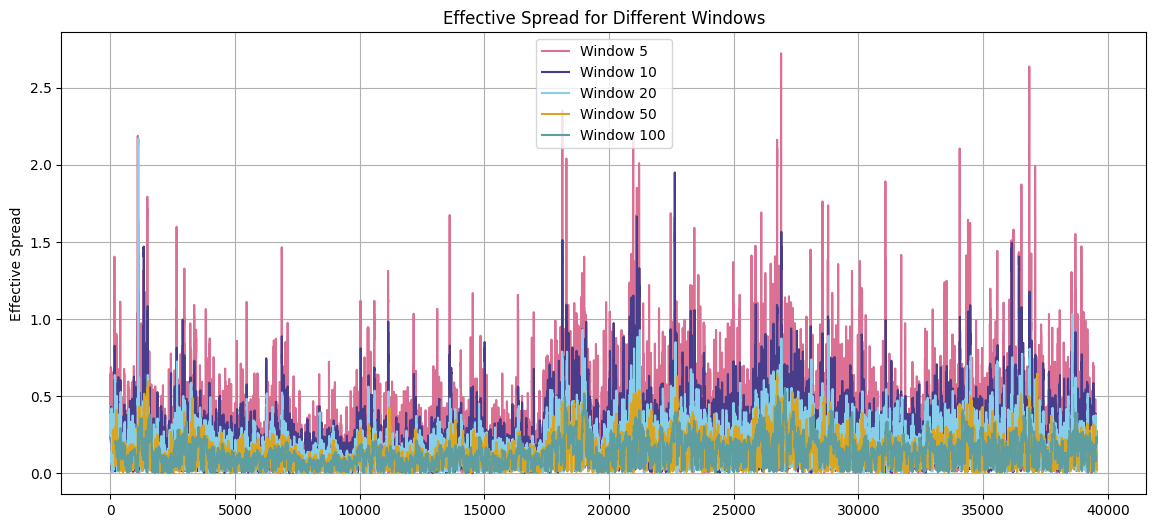

In [5]:
plt.figure(figsize=(14, 6))
colors = ['palevioletred', 'darkslateblue', 'skyblue', 'goldenrod', 'cadetblue']
for i, w in enumerate(window):
    plt.plot(data_block.index, data_block[f'Spread_{w}'], label=f'Window {w}', color=colors[i])

plt.title('Effective Spread for Different Windows')
plt.ylabel('Effective Spread')
plt.legend()
plt.grid()
plt.show()

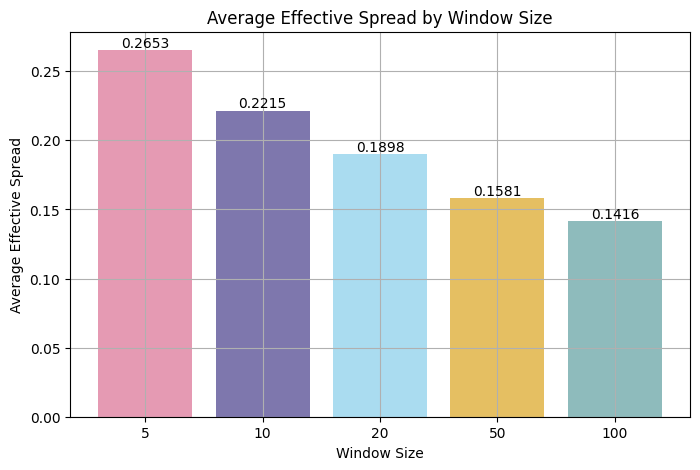

In [6]:
mean_spreads_block = []
for w in window:
    mean_spreads_block.append(data_block[f'Spread_{w}'].mean())

plt.figure(figsize=(8, 5))

labels = []
for w in window:
    labels.append(str(w))

bars = []
for i in range(len(labels)):
    bar = plt.bar(labels[i], mean_spreads_block[i], color=colors[i], alpha=0.7)
    bars.append(bar)
    plt.text(i, mean_spreads_block[i], f'{mean_spreads_block[i]:.4f}', ha='center', va='bottom', fontsize=10)

plt.title('Average Effective Spread by Window Size')
plt.xlabel('Window Size')
plt.ylabel('Average Effective Spread')
plt.grid()

## Serial covariance

In [7]:
def serial_covariance(data, window):
    data['D-1'] = data['Difference'].shift(1)
    for w in window:
        data[f'Cov_{w}'] = data['Difference'].rolling(window=w).cov(data['D-1'])
        data[f'Spread_{w}'] = 2 * np.sqrt(np.abs(data[f'Cov_{w}']))

    for i in range(len(window)):
        data[f'Bid_{window[i]}'] = np.where(data['Difference'] > 0, 
            data['Close'] - data[f'Spread_{window[i]}'], data['Close'])
        data[f'Ask_{window[i]}'] = np.where(data['Difference'] > 0, 
            data['Close'], data['Close'] + data[f'Spread_{window[i]}'])
                
    return data

In [8]:
serial_covariance(data_cov, window)

,Datetime,Open,High,Low,Close,Difference,BA,D-1,Cov_5,Spread_5,...,Bid_5,Ask_5,Bid_10,Ask_10,Bid_20,Ask_20,Bid_50,Ask_50,Bid_100,Ask_100
0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,-0.919998,bid,NaN,NaN,NaN,...,131.889999,NaN,131.889999,NaN,131.889999,NaN,131.889999,NaN,131.889999,NaN
1,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,0.169998,ask,-0.919998,NaN,NaN,...,NaN,132.059997,NaN,132.059997,NaN,132.059997,NaN,132.059997,NaN,132.059997
2,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,0.190003,ask,0.169998,NaN,NaN,...,NaN,132.250000,NaN,132.250000,NaN,132.250000,NaN,132.250000,NaN,132.250000
3,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,-0.660004,bid,0.190003,NaN,NaN,...,131.589996,NaN,131.589996,NaN,131.589996,NaN,131.589996,NaN,131.589996,NaN
4,2021-01-04 14:55:00,132.000000,132.089996,131.300003,131.448898,-0.141098,bid,-0.660004,NaN,NaN,...,131.448898,NaN,131.448898,NaN,131.448898,NaN,131.448898,NaN,131.448898,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39567,2022-12-30 20:40:00,129.029998,129.130004,128.919998,129.054992,0.014999,ask,0.019989,-0.002153,0.092807,...,128.962185,129.054992,128.884329,129.054992,128.965072,129.054992,128.975079,129.054992,128.922074,129.054992
39568,2022-12-30 20:45:00,129.059997,129.399993,129.020004,129.380004,0.325012,ask,0.014999,-0.002983,0.109240,...,129.270764,129.380004,129.195466,129.380004,129.259212,129.380004,129.291819,129.380004,129.246591,129.380004
39569,2022-12-30 20:50:00,129.375000,129.929992,129.330001,129.764404,0.384400,ask,0.325012,0.013455,0.231993,...,129.532411,129.764404,129.690239,129.764404,129.712092,129.764404,129.712193,129.764404,129.612325,129.764404
39570,2022-12-30 20:55:00,129.764999,129.949996,129.619995,129.949996,0.185592,ask,0.384400,0.011183,0.211500,...,129.738496,129.949996,129.806255,129.949996,129.858353,129.949996,129.860760,129.949996,129.788603,129.949996


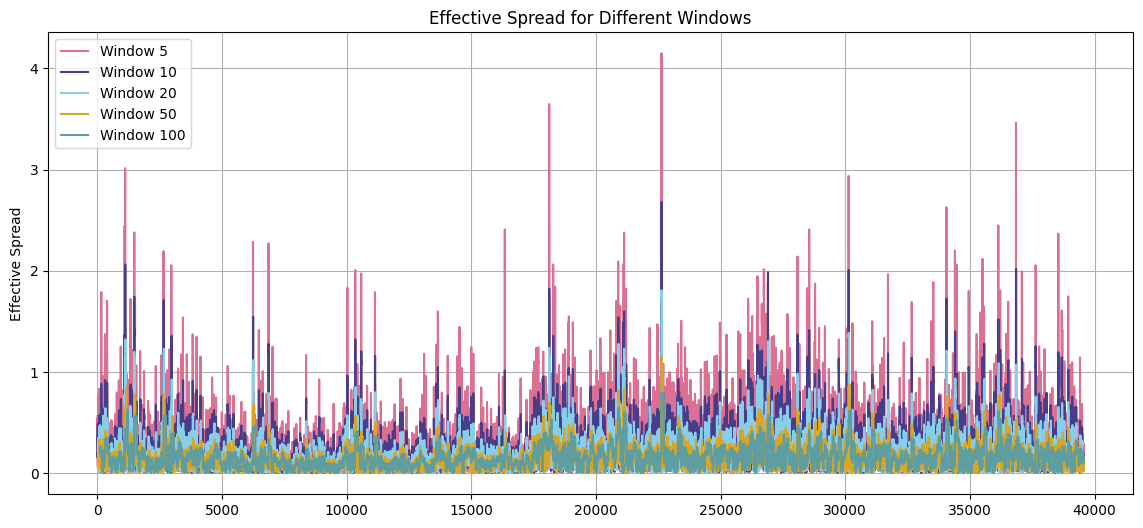

In [9]:
plt.figure(figsize=(14, 6))
colors = ['palevioletred', 'darkslateblue', 'skyblue', 'goldenrod', 'cadetblue']
for i, w in enumerate(window):
    plt.plot(data_cov.index, data_cov[f'Spread_{w}'], label=f'Window {w}', color=colors[i])

plt.title('Effective Spread for Different Windows')
plt.ylabel('Effective Spread')
plt.legend()
plt.grid()
plt.show()

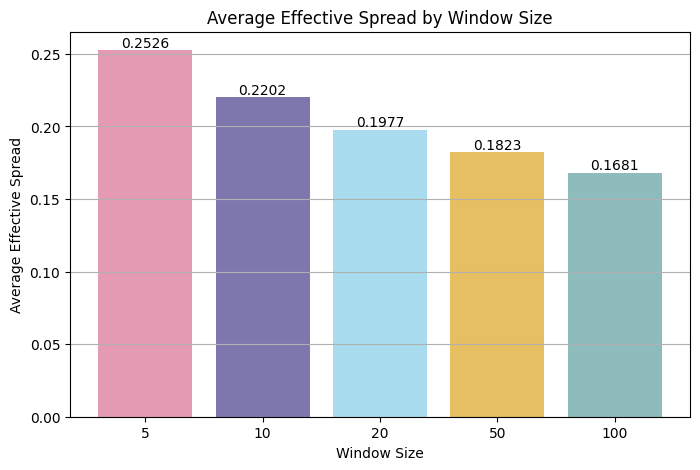

In [10]:
mean_spreads_cov = []
for w in window:
    mean_spreads_cov.append(data_cov[f'Spread_{w}'].mean())

plt.figure(figsize=(8, 5))

labels = []
for w in window:
    labels.append(str(w))

colors = ['palevioletred', 'darkslateblue', 'skyblue', 'goldenrod', 'cadetblue']
bars = []
for i in range(len(labels)):
    bar = plt.bar(labels[i], mean_spreads_cov[i], color=colors[i], alpha=0.7)
    bars.append(bar)
    plt.text(i, mean_spreads_cov[i], f'{mean_spreads_cov[i]:.4f}', ha='center', va='bottom', fontsize=10)

plt.title('Average Effective Spread by Window Size')
plt.xlabel('Window Size')
plt.ylabel('Average Effective Spread')
plt.grid(axis='y')

plt.show()

## Visualización series de tiempo

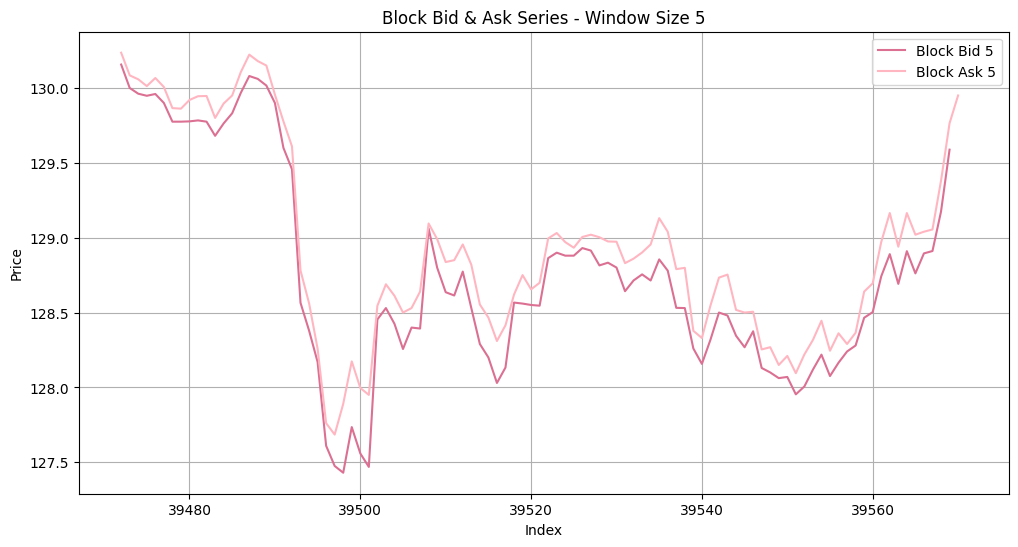

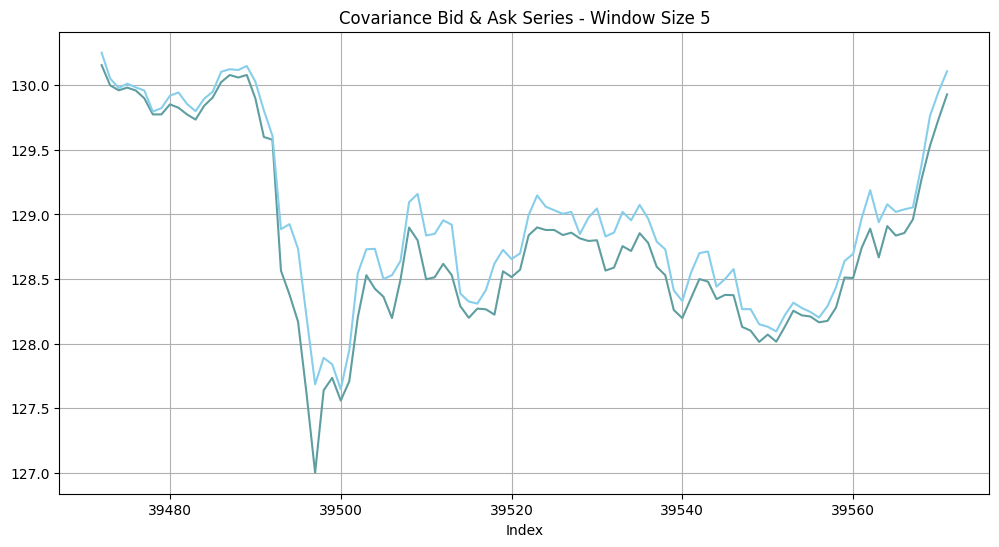

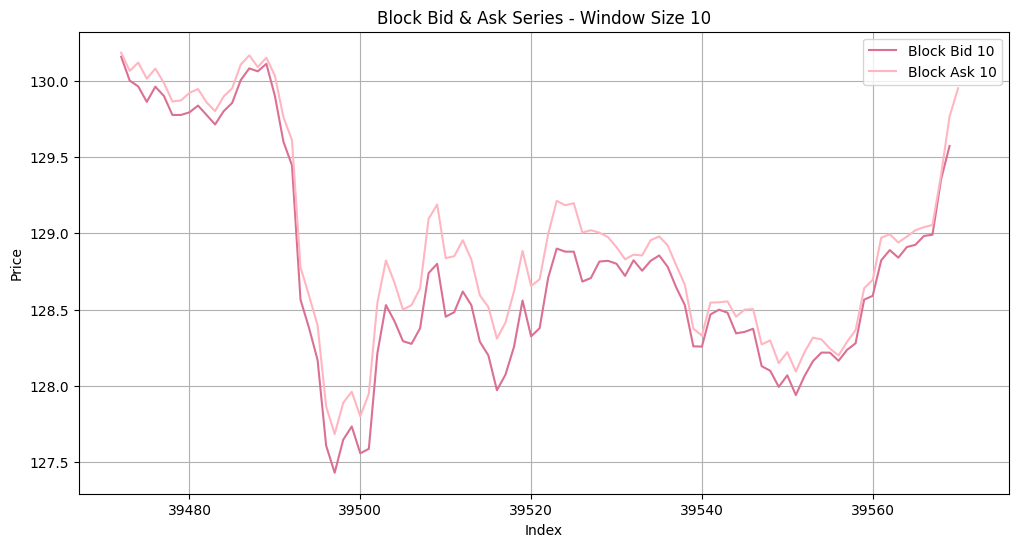

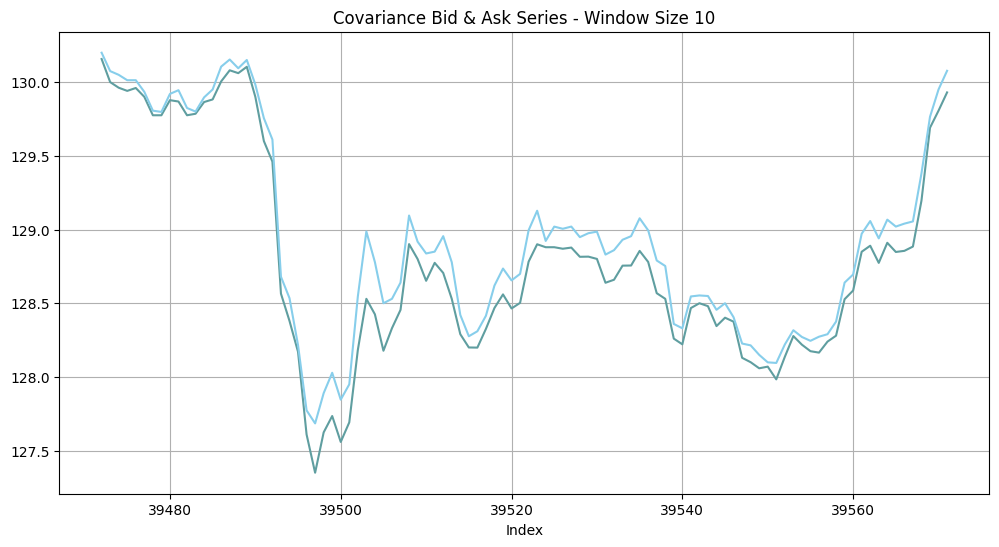

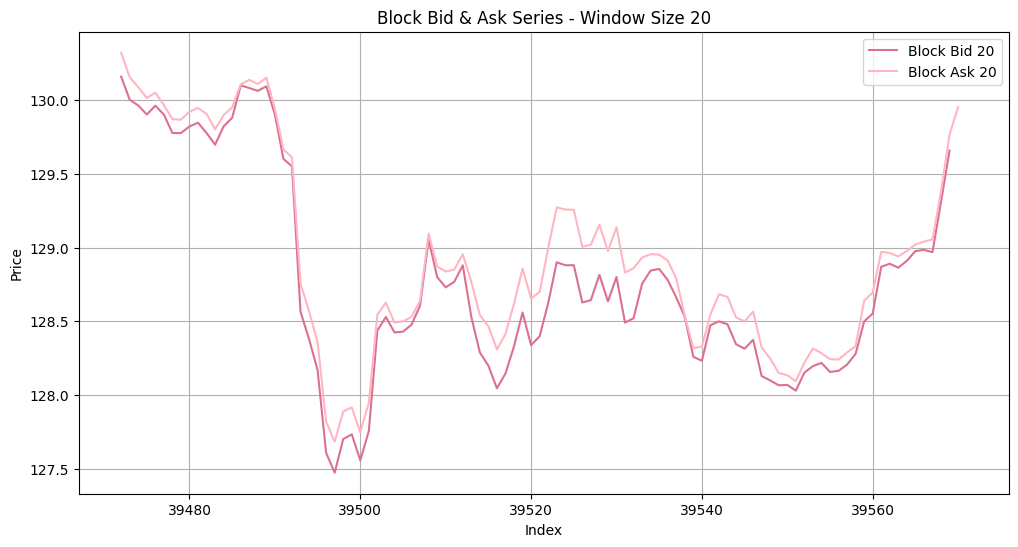

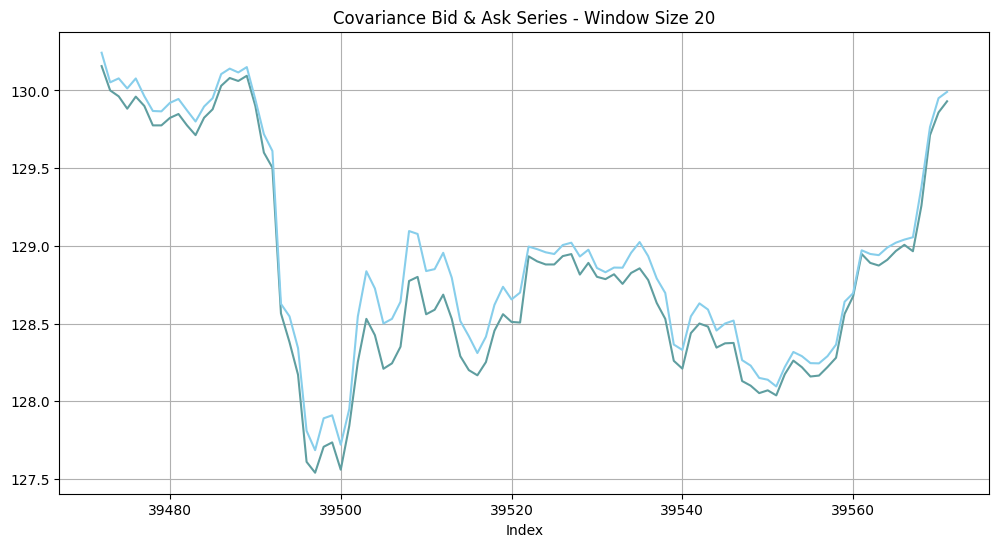

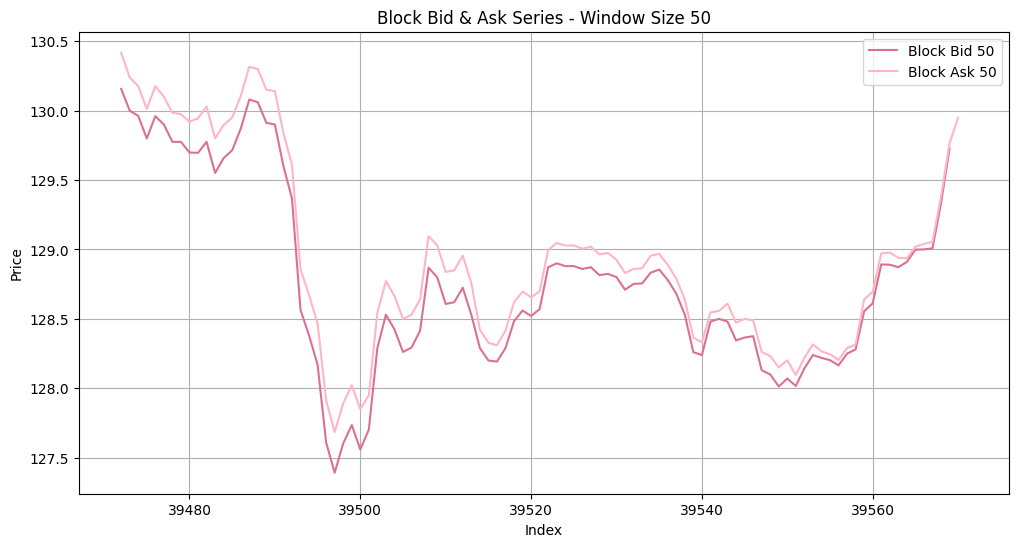

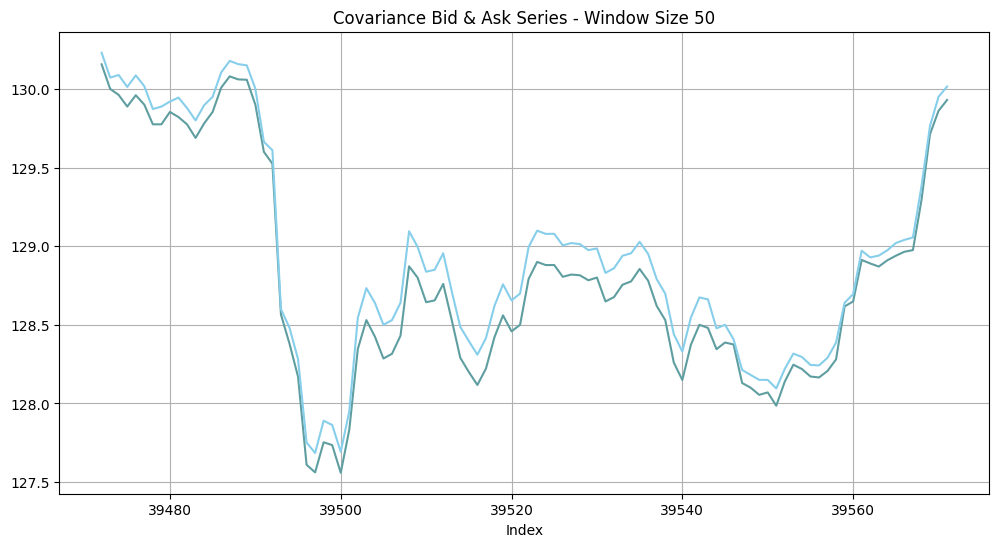

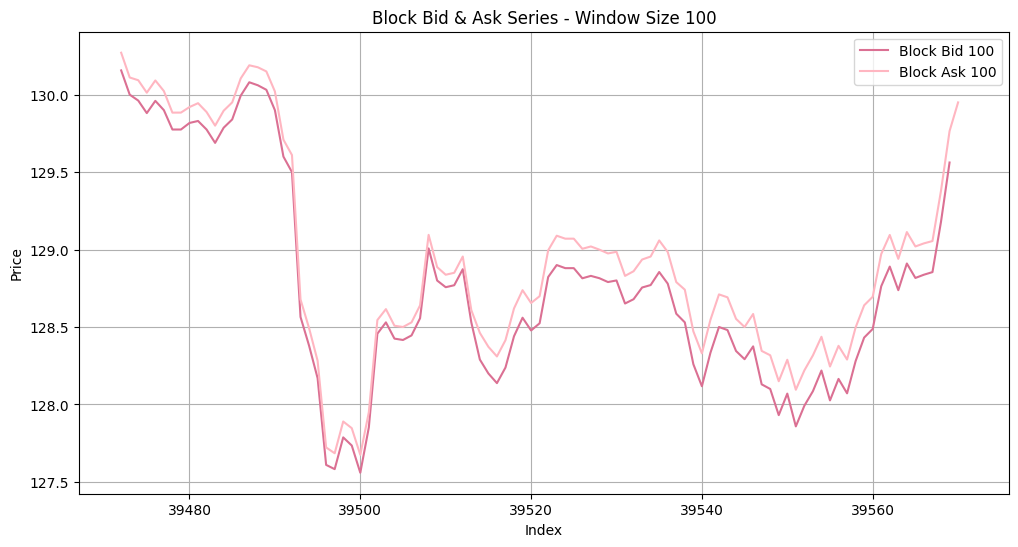

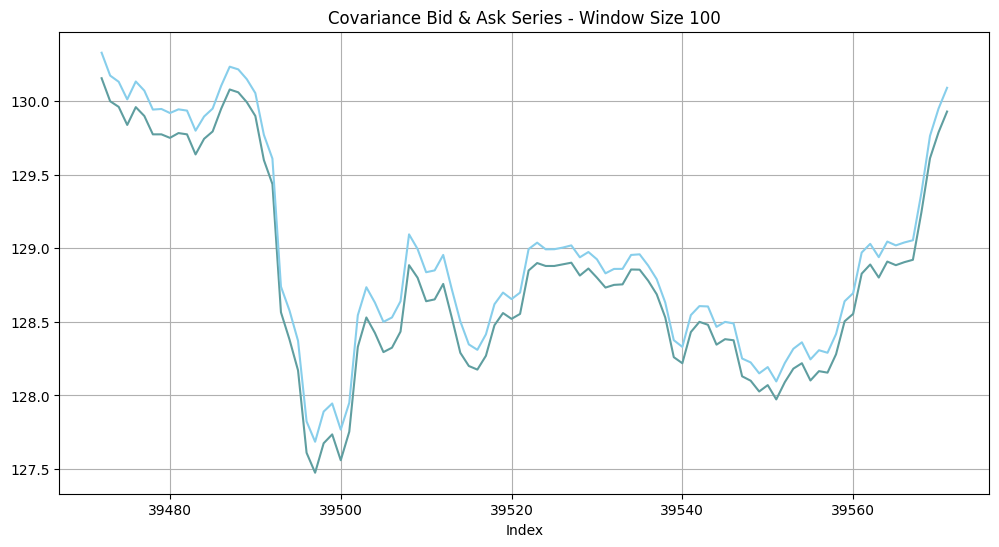

In [11]:
for w in window:
    # Block method
    plt.figure(figsize=(12, 6))
    plt.plot(data_block[f'Bid_{w}'].tail(100), label=f'Block Bid {w}', color='palevioletred')
    plt.plot(data_block[f'Ask_{w}'].tail(100), label=f'Block Ask {w}', color='lightpink')
    plt.title(f'Block Bid & Ask Series - Window Size {w}')
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Covariance method
    plt.figure(figsize=(12, 6))
    plt.plot(data_cov[f'Bid_{w}'].tail(100), label=f'Cov Bid {w}', color='cadetblue')
    plt.plot(data_cov[f'Ask_{w}'].tail(100), label=f'Cov Ask {w}', color='skyblue')
    plt.title(f'Covariance Bid & Ask Series - Window Size {w}')
    plt.grid()
    plt.xlabel('Index')

## Comparación

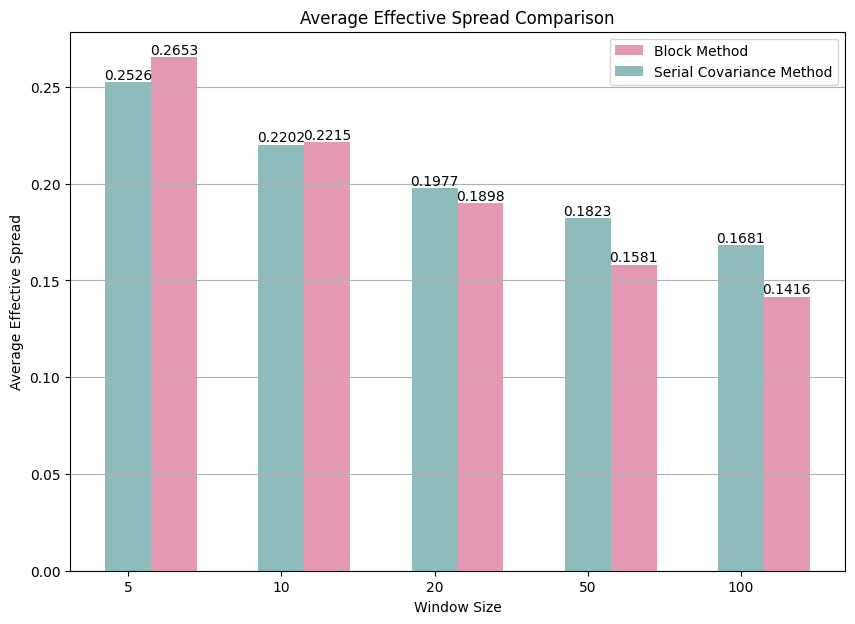

In [12]:
x = np.arange(len(labels))
plt.figure(figsize=(10, 7))

bars_block = plt.bar(x + 0.3, mean_spreads_block, 0.3,
                color='palevioletred', label='Block Method', alpha = 0.7)
bars_cov = plt.bar(x, mean_spreads_cov, 0.3,
                color='cadetblue', label='Serial Covariance Method', alpha = 0.7)

for i in range(len(labels)):
    plt.text(x[i] + 0.3, mean_spreads_block[i], f'{mean_spreads_block[i]:.4f}', 
             ha='center', va='bottom', fontsize=10)
    plt.text(x[i], mean_spreads_cov[i], f'{mean_spreads_cov[i]:.4f}', 
             ha='center', va='bottom', fontsize=10)
    
plt.xticks(x, labels)
plt.title('Average Effective Spread Comparison')
plt.xlabel('Window Size')
plt.ylabel('Average Effective Spread')
plt.legend()
plt.grid(axis='y')
plt.show()

## Conclusiones
<div style="text-align: justify">

Al comparar los resultados obtenidos en ambos métodos, se puede observar que, en el <span style="color:palevioletred"> **método de bloque**</span>, en las ventanas menores se tiene un promedio de spread efectivo ligeramente mayor al <span style="color:cadetblue">**método de covarianza serial**</span>, cosa que se invierte en los casos de las ventanas de 20, 50 y 100.

Los valores promedio del spread efectivo tienden a decrecer a medida que la ventana se hace más grande. El promedio del spread efectivo de AAPL usando el método de bloques y el método de covarianza serial se muestra en las gráficas y tablas anteriores. 

Para esta serie de tiempo, el <span style="color:cadetblue">**método de covarianza serial**</span> se ajusta mejor, ofrece spreads efectivos más estables y menos sensibles a fluctuaciones extremas en los precios. Este método utiliza la relación entre diferencias consecutivas, lo que permite captar mejor los cambios recientes en la dinámica del mercado. Además, los valores promedio del spread calculados con covarianza serial muestran menor variabilidad y se alinean más con el comportamiento observado en la serie de AAPL, facilitando una interpretación más precisa.

</div>